### The Building blocks of CNNs

conv architectures are often described as feature extraction layers

### Understanding CNNs and feature heirarchies

CNNs can automatically learn the features from raw data that are 
most useful for a particular task. so it's common to consider CNN
layers as feature extractors. 

these are the first layers and later their findings are exploited by 
fully connected layers/MLPs. 

feature heirarchy: constructed by deep CNNs where they combine 
low level features in a layer wise fashion to form high level features
for example, edges and blobs extracted from earlier layers are 
combined to form high level features. these high level features can 
form more complex shapes

local receptive field: local patch of pixels which correspond to only one element of the feature matrix.

cnns work well because of two ideas
1. sparse connnectivity: opposed to fully connected layers where each pixel
is connected to the hidden nodes, only a selected pixels are connected to each node in the feature map. 
2. parameter sharing: same weights are used for different patches of the input image. 

as a result, using a convolution layer substantially reduces the number of weights. 
it makes sense to assume nearby pixels are correlated in an image. 
it improves the ability to capture salient features.

typical cnn has several convolution and subsampling layer with fully connected layers at the end. 
these subsampling layers are also called pooling layers and have no parameters. only the convolution layers
and the fully connected layers have learnable parameters. 

### Performing discrete convolutions

fundamental operation in a cnn

a discrete convolution for two vectors x and w is denoted by y = x * w. x is the input and w is the filter/kernel. 
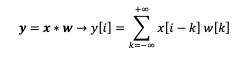

here the summation runs from negative infinite to infinite. in machine learning, we only work with finite 
feature vectors. so this is not useful in practical application. in practice, x is padded with a finite 
number of zeros. 

this is called zero-padding. 

so if x originally had n elements, the padded x would have n+2p (2 p because p zeros are padded on each side)

now the equation becomes

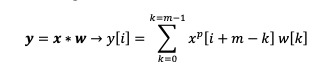

how much the filter moves is called stride. it should always be a positive number less that the number of elements in the input vector.

_Cross Correlation_

it is similar to a convolution operation but in cross correlation you don't invert the filter. many deep learning frameworks implement this but call it as convolution. the same rules of padding and stride apply to this. 

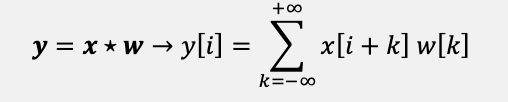

depending on the padding value, the way conv layer treats boundary cells from middle cells of the image will vary. 

to stop this artificial way of treating middle elements differently, we can pick a padding value such that the output layer will have the same number of elements as the input layer ie., each element will be used equal number of times to compute the output element.

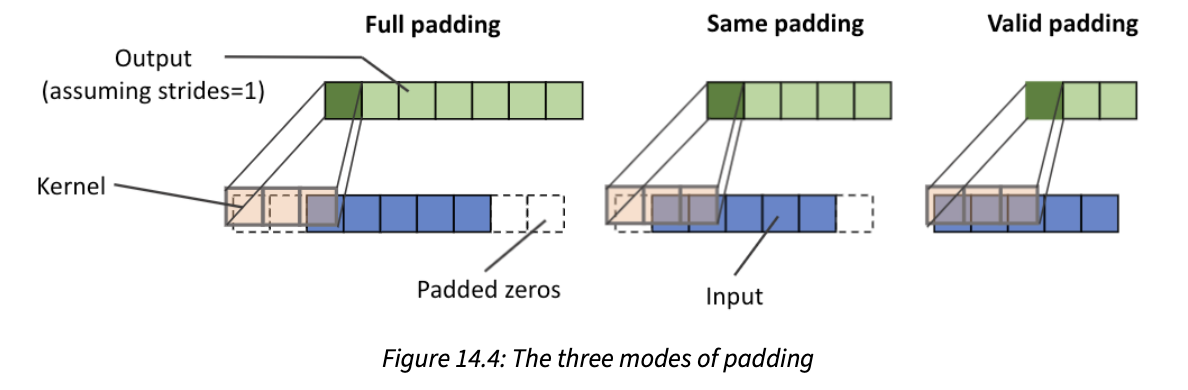

most common mode of padding is this same padding aka same size output as that of input. 

valid padding is where you have no padding at all and it is at a disadvantage to the models that have padding, they have significantly fewer number of inputs as the depth increases. 

in practice, to reduce the number of inputs, one should use pooling layers or conv layers with stride 2 instead. 

full padding where you get larger output than the input, is useful in signal processing applications where it is important to minimize the boundary effects. 

_determining size of convolution outpu in 1d_

n is the size of input vector

m is the size of the filter

p is the padding

s is the stride

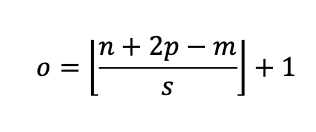

### Convolution in 1D

In [9]:
import numpy as np

def conv1d(x, w, p= 0, s= 1):
    w_rotated = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape = p)
        x_padded = np.concatenate([zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rotated))) + 1, s):
        res.append(np.sum(x_padded[i:i+w_rotated.shape[0]] * w_rotated))
    return np.array(res)        

In [14]:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]
print(conv1d(x, w, p =2, s = 1)) 

[ 5. 14. 16. 26. 24. 34. 19. 22.]


In [15]:
np.convolve(x, w, mode = 'same')

array([ 5, 14, 16, 26, 24, 34, 19, 22])

same concept can easily be extendable to 2d. 

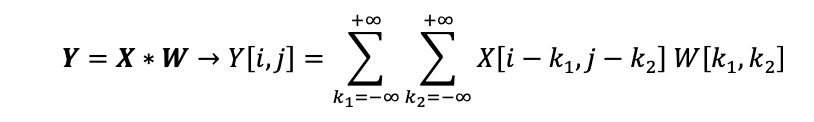

rotation of filter is not just transpose. each row is reversed and each column is reversed in 2d. 

⨀ is the symbol for element wise product of two matrices. 

### convolution in 2d.

In [25]:
import numpy as np
import scipy.signal

def conv2d(X, W, p = (0, 0), s = (1, 1)):
    W_rotated = np.array(W)[::-1, ::-1]
    X_original = np.array(X)
    n1 = X_original.shape[0] + 2 * p[0]
    n2 = X_original.shape[1] + 2 * p[1]
    X_padded = np.zeros(shape = (n1, n2))
    X_padded[p[0]:p[0]+X_original.shape[0], p[1]:p[1]+X_original.shape[1]] = X_original
    
    res = []
    for i in range(0, int((X_padded.shape[0] - W_rotated.shape[0])/s[0]) + 1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - W_rotated.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rotated.shape[0], j:j+W_rotated.shape[1]]
            res[-1].append(np.sum(X_sub * W_rotated))
    return np.array(res)
    

In [26]:
X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

In [27]:
print(conv2d(X, W, p = (1, 1), s = (1, 1)))

[[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]


In [28]:
print(scipy.signal.convolve2d(X, W, mode = 'same'))

[[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


filter matrices are not actually rotated in pytorch. this naive implmentation is very computationally inefficient. 

### subsampling layers

typically two types: max-pooling and mean-pooling/average-pooling. 

pooling introduces local invariance. which means small changes in local neighbourhood do not impact the result of max pooling. pooling also reduces the number of features. 

pooling is typically not overlapping. ie., if pooling layer size is n1xn2, the stride will be (n1, n2). however there are some cases where overlapping pooling was used (the original imagenet paper for example)

while pooling is esesntial, many people use conv layer with stride 2 to reduce the size instead of using pooling. in a way you can think of conv layer with stride 2 as a learnable pooling layer. 

### implementing simple cnn

conventional conv layers expect an input of rank 3 tensor. the third dimension will be the channel. 

##### reading an image file

one way to reduce the memory consumption while loading images is to load them in unint8 format. 

we perform convolution on each channel and then merge the results together using matrix summation. 

#### regularizing an nn with l2 regularization and dropout

one way to avoid overfit or underfit is to build a network with relatively larger capacity (larger than required) to do well on training dataset and then we apply a regularization scheme to achieve good generalization on new data. 

one regularization technique is to add the l1 or l2 penalty term. l2 is commonly used in deep learning. another tehnieuq is dropout. 

#### using l2 iwht a conv network in pytorch

In [5]:
import torch.nn as nn

loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([.9]), torch.tensor([1.0]))

l2_lambda = .001
conv_layer = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = 5)
l2_penalty = l2_lambda * sum([(p ** 2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_lambda = .001
l2_penalty = l2_lambda * sum([(p ** 2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty


# an alternative way to use l2 regularization is to set weight_decay parameter in optimzer
# for example
# optimizer = torch.optim.SGD(model.parameters(), lr = .001, weight_decay = l2_lambda)

# while weight decay and l2 regularization are not equal, they are equivalent in the 
# case of sgd optimizer

dropout is another latest technique to regularize. it's applied to the hidden nodes and layers where a fraction of nodes are dropped every iteration with prob p_drop. most common value is .5

when nodes are dropped, the other weights are rescaled to account for the missing nodes. 

the effect is that the network is forced to learn with only a partial representation of the data and not rely on any specifc activation node set. 

during prediction all nodes will be used no dropout is used during inference and prediction ie., p_drop = 0. 

inverse dropout: when you double the activations when you have dropout prob as .5 to counteract the lack of nodes. not just double, could be any value depending on p_drop. this is generally seen in tools like pytorch. 

dropout is also similar to ensemble models because in each mini batch you have a different model because of different nodes. the key difference between a regular ensemble model and a dropout model is that the weights are shared in a model with dropout. 

#### Loss Functions for Classification

Binary Cross Entropy for Binary Classification and Categorical Cross Entropy for Multi Class Classification are good choices. 

You can use logits or the probabilities with these loss functions. 

Binary Classification + Probs -> nn.BCELoss

Binary Classification + Logits -> nn.BceWithLogitsLoss

Multi Class + Probs -> nn.NLLoss

Multi Class + Logits -> nn.CrossEntropyLoss

In [8]:
logits = torch.tensor([.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(f"BCE with Probs: {bce_loss_fn(probas, target): .4f}\tBCE without Probs: {bce_logits_loss_fn(logits, target):.4f}")

BCE with Probs:  0.3711	BCE without Probs: 0.3711


In [18]:
logits = torch.tensor([[1.5, .8, 2.1]])
probas = torch.softmax(logits, dim = 1)
target = torch.tensor([2])
# NLLLoss() expects the log probabilities of each class
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()
print(f"CCE with Probs: {cce_loss_fn(torch.log(probas), target): .4f}\tCCE without Probs: {cce_logits_loss_fn(logits, target):.4f}")

CCE with Probs:  0.5996	CCE without Probs: 0.5996


CrossEntropyLoss() can also be used for binary classification if the probabilities of both classes are required. When you use BCELoss() you only get the probabilty of the predicted class, if you need the other class's probability, you need to subtract it from 1. To overcome this you can use CrossEntropyLoss() instead. But you need to use the softmax activation before you pass them to the loss function. 

#### Implementing a deep CNN using PyTorch
Architecture
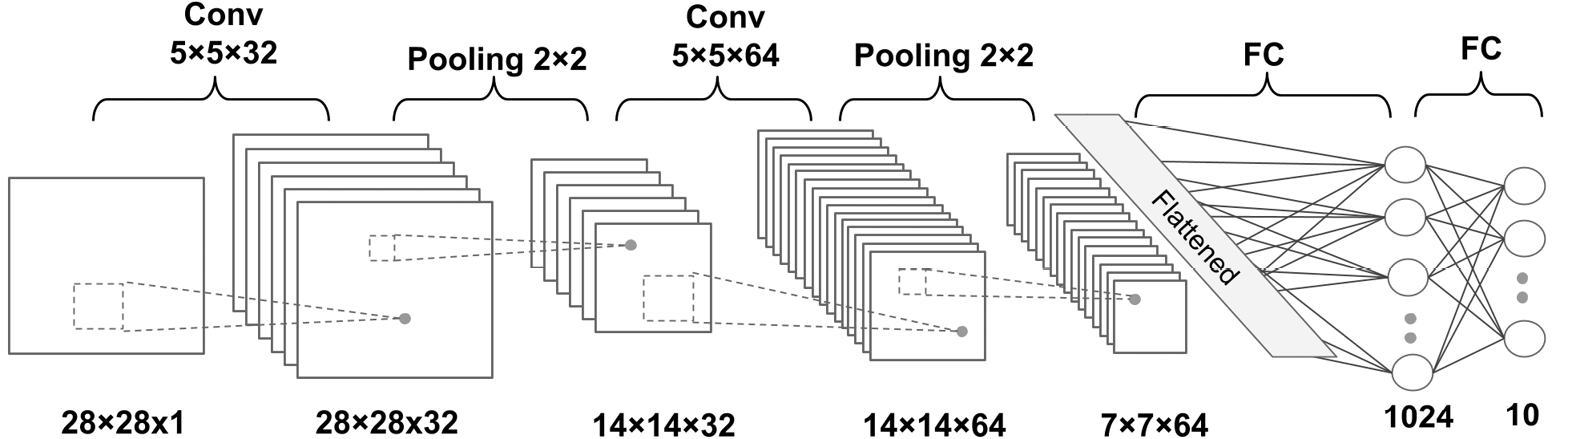

stride = 1 for the convolution layers ad kernel_size = 2 for the pooling layers

In [19]:
import torchvision
from torchvision import transforms

image_path = './'
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = torchvision.datasets.MNIST(root = image_path, train = True, transform = transform, download = True)

In [20]:
from torch.utils.data import Subset
# the data is not sorted in class wise order. so we can pick the first 10k for validation
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root = image_path, train = False, transform = transform, download = False)

In [21]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle = True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle = False)

torch.nn provides classes for 


conv: nn.Conv2d

maxpool: nn.MaxPool2d

avgpool: nn.AvgPool2d

dropout: nn.Droout

we need to specify the number of output channels/number of output feature maps/number of output filters and the kernel size in the nn.Conv2d layer. 
there are also additional options like padding, strides (default is (1, 1))

NCHW format = Number of images in batch, Channels, Height, Width

nn.Conv2d assumes the image is in this format

tensorflow assumes it to be NHWC

nn.Dropout takes the prob as parameter

model.train() and model.eval() can be used to control it's behaviour. 

In [27]:
model = nn.Sequential()

model.add_module('conv1', nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5, padding = 2))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2))
model.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 2))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2))


In [28]:
# we can calculate the size of feature maps at this stage manually
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [29]:
# the next layer will be the fully connected layer which needs to be of rank 2 ie., batch_size x input_units
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape
# 4 rank tensor converted to 2 rank

torch.Size([4, 3136])

In [30]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p = .5))
model.add_module('fc2', nn.Linear(1024, 10))
 
# we don't need to add nn.Softmax because nn.CrossEntropyLoss() already implements it

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = .001)

In [ ]:
def train()